# TD4: Sparse dictionary decomposition

In this session, we will solve an inverse problem with a Lasso regularization. First, we will do so with a gradient descent.

## Mathematical framework
A signal $f \in \mathbb R^N$ is can be decomposed in a dictionary $\Phi$ of size $(P, N)$ (typically, $P > N$):
$$
    f = \Phi^* a = \sum_{p=0}^{P-1} a[p] \, \psi_p
$$
Where $\Phi^*$ is the conjugate transpose of $\Phi$, the $\psi_p \in \mathbb R^N$ correspond to the line of $\Phi$:
$$
    \Phi^* = \left( \psi_1 \middle| \dots \middle| \psi_P \right)
$$
and $a[p] \in \mathbb R$ are the coordinates of $a$. The vector $a \in \mathbb R^P$ is a decomposition of $f$ in the dictionary $\Phi$. Our aim is to find a sparse decomposition of $f$ in $\Phi$.


As seen in class, $\| . \|_0$ is non-convex, minimizing it in intractable (i.e. extremely expensive computationaly speaking). A convex relaxation consists in using the $\| . \|_1$ norm instead, which will allow us to obtain a solution. Research has been done to motivate the prove that this norm results in sparse decomposition.
$$
    \texttt{minimize} \quad \|a\|_1 \quad \texttt{subject to} \quad \|f - \Phi^* a\|_2^2 \leq \epsilon
$$

The dual formulation of this convex problem consists in minimizing the following problem instead:
$$
    \texttt{minimize} \quad \mathcal L(x) = \frac{1}{2}\|f - \Phi^* a\|_2^2 + \lambda \|a\|_1
$$
where $\lambda$ is a dual variable corresponding to the precision $\epsilon$

Our prior on the signal is that it should be sparse in a wavelet dictionary. This corresponds to being locally smooth almost everywhere.

Here, $\Phi$ will be a dictionary of wavelet. This dictionary contains one wavelet per scale $j$, and per position $n \in \{0, \dots, N-1\}$. We thus have $P = J \times N$ atoms $\psi_{j, \delta n}[n] = \psi_j[n - \delta n]$ in the wavelet dictionary. The matrix $\Phi$ has size $(J \times N, N)$. For simplicity, the index $p \in \{0, \dots, J\times N -1\}$ is replaced by $(j, \delta n)$, meaning that we will note $\psi_{j, \delta n}$ instead of $\psi_p$ and $a[j, \delta n]$ instead of $a[p]$:
\begin{align*}
    \Phi^* a(n) &= \sum_{j=0}^{J-1} \sum_{\delta n=0}^{N-1} \psi_{j, \delta n}[n] \, a[j, \tau] \\
    &= \sum_{j=0}^{J-1} \sum_{\delta n=0}^{N-1} \psi_j[n - \delta n] a[j, \delta n] \\
    &= \sum_{j=0}^{J-1} \psi_j \ast a_j (n)
    \quad \text{where} \quad a_j[\delta n] = a[j, \delta n]
\end{align*}

It is more efficient both memory-wise and time-wise to perform this convolution rather than store a wavelet for each lag $\tau$ and compute all scalar product.
We will thus only store a set of centered wavelets $\{\psi_j\}_{j=0}^{J-1}$:
$$
    \forall n \in \{0, \dots, N-1\}, \quad \Phi^* a[n] = \sum_{j=1}^J \psi_j \ast a_j [n]
$$

## Fourier notations in this notebook

The Fourier transform $\hat f$ of discrete function $f$ is defined for all $k \in \{\frac{-(N-1)}{2}, \dots, \frac{(N-1)}{2}\}$ as:
$$
    \hat f[k] = \frac{1}{N} \sum_{n=0}^{N-1} f[n] e^{\frac{-2i\pi k n}{N}}
$$
Because this is the convention adopted by python, we will rather use the fourier frequency $\omega = k / N \in [-0.5, 0.5]$ ($\omega$ takes $N$ evenly spaced values in this interval), which means that we replace the previous definition with:
$$
    \hat f[\omega] = \frac{1}{N} \sum_{n=0}^{N-1} f[n] e^{-2i\pi \omega n}
$$

### A note on the relation between "Fourier frequency" and "frequency"
Fourier frequences are indeed related to the notion of audio frequency: if the audio was recorder with $N_0$ samples per seconds, we can use the time variable $t = n / N_0$ instead of $n$, which means:
$$
    \hat f[\omega] = \frac{1}{N} \sum_{t=0}^{(N-1)/N_0} f[N_0 t] e^{-2i\pi \omega N_0 t}
$$
Then the harmonic has frequency $\omega N_0$, measured in Hertz (periods per seconds).

## Input Data
We will use a piano note as input data $f$, which is in file `piano_4s_4096.npy`

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

from morlet_filters import morlet_1d

# this line can cause problems if tqdm is not installed
try:
    from tqdm import tqdm_notebook as tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs): return iterator

def figure(width=12, height=6, **kwargs): plt.figure(figsize=(width, height), **kwargs)

In [2]:
f = np.load("piano_4s_4096.npy")
f = f / np.max(np.abs(f))  # renormalize so maximum absolute value is 1
sr = 4096  # sampling rate, i.e. number of samples per seconds in the recording
Audio(f, rate=sr)

## Dictionary of Morlet wavelets
$\Phi$ is a dictionary of Morlet wavelets. A centered Morlet wavelet is constructed from Gabor filters:
$$
    \hat \psi_j^{Gabor}[\omega] = e^{\frac{-(\omega - \omega_j)^2}{2\sigma_j^2}}
$$
where $\omega_j = 2^{-j} \omega_0$ and $\sigma_j = 2^{-j} \sigma_0$ are defined with respect to two constants $\omega_0$ and $\sigma_0$ which have been computed for the gabor dictionary to have certain properties which go beyond the scope of this notebook.

$$
    \hat \psi_j(\omega) = e^{\frac{-(\omega - \omega_j)^2}{2\sigma_j^2}} - \beta_{\omega_j, \sigma_j} e^{\frac{-\omega_j^2}{2\sigma_j^2}} 
$$
with $\beta_{\omega_j, \sigma_j}$ such that $\hat \psi_j(0) = 0$

However, these wavelet are complex, we get real wavelets by only using their real parts.

In [3]:
N = np.size(f)
Q = 12  # number of wavelet per octave
J = int(np.log(N))  # number of octaves, note that some wavelets here may be to low for us to hear

A Morlet wavelet function has been defined in the file `morlet_filters.py`, you can use the function `morlet_1d` to define a morlet filter centered arround frequency $\omega_0$ as shown below. $Q$ is the number of wavelet per octave, here we take $Q=12$ because there are $12$ half-tone per octave.

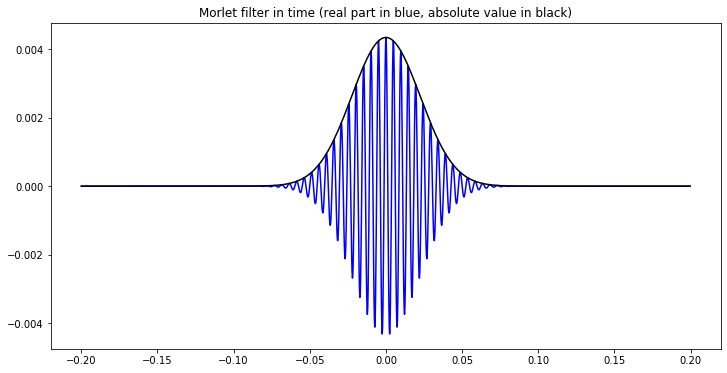

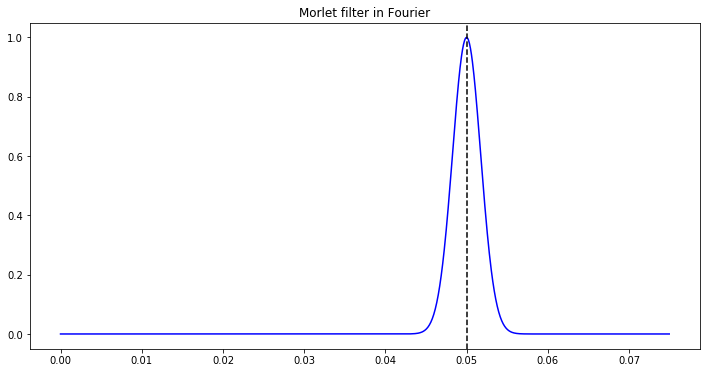

In [4]:
omegaj = .05
morlet_hat = morlet_1d(N, omegaj, Q)
morlet = np.fft.ifft(morlet_hat)

# Make a fidget to be able to listen to the wavelet. The wavelet is shifted by N/2 so it is in one piece.
display(Audio(np.roll(np.real(morlet), N//2), rate=2**12))


dr = int(.2 * sr)  # Range of x axis
figure()
# plot the wavelet function in time domain. It is complex so we plot its real part and its absolute value
plt.plot(np.arange(-dr, dr)/sr, np.fft.fftshift(np.real(morlet))[N//2 - dr:N//2 + dr], color='b')
plt.plot(np.arange(-dr, dr)/sr, np.fft.fftshift(np.abs(morlet))[N//2 - dr:N//2 + dr], color='k')
plt.title("Morlet filter in time (real part in blue, absolute value in black)")
plt.show()

figure()
freq = np.fft.fftfreq(N)
mask = np.logical_and(freq >= 0, freq <= 1.5 * omegaj)  # range of x axis, corresponding to Fourier frequencies omega
plt.plot(freq[mask], np.abs(morlet_hat)[mask], color='b')  # plot absolute value of wavelet in Fourier domain
plt.axvline(x=omegaj, color='k', ls='--')
plt.title("Morlet filter in Fourier")
plt.show()

In [5]:
omega0 = 0.475
# define the dictionary of wavelet: all morlet parameters omega_j and sigma_j are obtained as dilations of omega_0
omegajs = [omega0 * np.power(2, -jq/Q) for jq in range(J*Q)]

# from omega_j we can define all wavelets with morlet_1d
psi_hat = [morlet_1d(N, omegaj, Q) for omegaj in omegajs]

# for each wavelet, take its real part and compute the fourier transform again
psi = [np.real(np.fft.ifft(psi_h)) for psi_h in psi_hat]
psi_hat = [np.fft.fft(psi_) for psi_ in psi]

# we stack this list of vectors in order to have a single matrix Phi
psi_hat = np.stack(psi_hat, axis=0)
print("Signal size: N={}\nNumber of scales: J={}".format(psi_hat.shape[1], psi_hat.shape[0]))

Signal size: N=16384
Number of scales: J=108


# Your time to work !

### Question 0: Display the wavelet dictionary

#### 0.a/ On a single graph with frequencies from 0 to 0.5 on x-axis, display the modulus of all wavelets in the dictionary

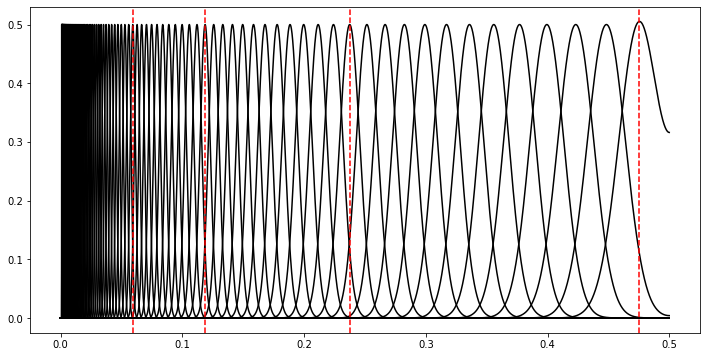

In [6]:
freq = np.fft.fftfreq(N)

plt.figure(figsize=(12, 6))
# the signal is real, so we know that the negative frequencies are simply the complex conjugate of positive
# frequencies: hat x[-omega] = hat x[omega]^*
# This means that we can work with the positive frequencies omega between 0 and 0.5 without loosing information
plt.plot(freq[:N//2], np.abs(psi_hat[:, :N//2].T), color="k")
plt.axvline(x=omega0, color="r", ls="--")
plt.axvline(x=omega0/2, color="r", ls="--")
plt.axvline(x=omega0/4, color="r", ls="--")
plt.axvline(x=omega0/8, color="r", ls="--")
plt.show()

#### 0.b/ Still in Fourier, display for each frequency $\omega$ the energy $\mathcal E(\omega) = \sum_{\psi \in D} |\psi(\omega)|^2$ of the dictionary at that frequency.
Note: The ratio $\max_\omega \mathcal E(\omega) / \min_\omega \mathcal E(\omega)$ is linked to the ability to invert the dictionary transform: the closer to $1$ the better.

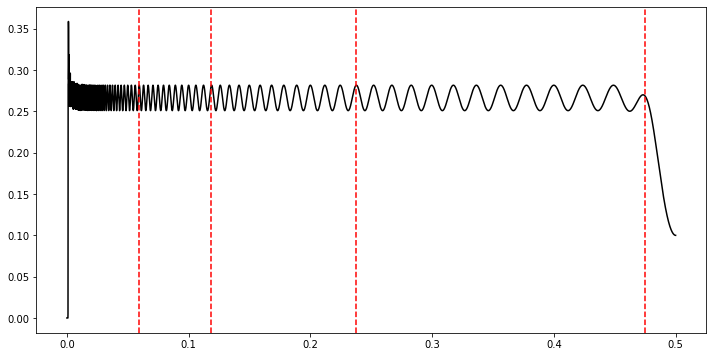

In [7]:
freq = np.fft.fftfreq(N)

plt.figure(figsize=(12, 6))
plt.plot(freq[:N//2], np.sum(np.abs(psi_hat[:, :N//2])**2, axis=0), color="k")
plt.axvline(x=omega0, color="r", ls="--")
plt.axvline(x=omega0/2, color="r", ls="--")
plt.axvline(x=omega0/4, color="r", ls="--")
plt.axvline(x=omega0/8, color="r", ls="--")
plt.show()

Here we notice that the energy is well-concentrated between $1$ and $1.2$ for most of the frequencies. Notice that usually we would need a low-pass filter, but here this low-pass corresponds to frequencies below our hearing range.

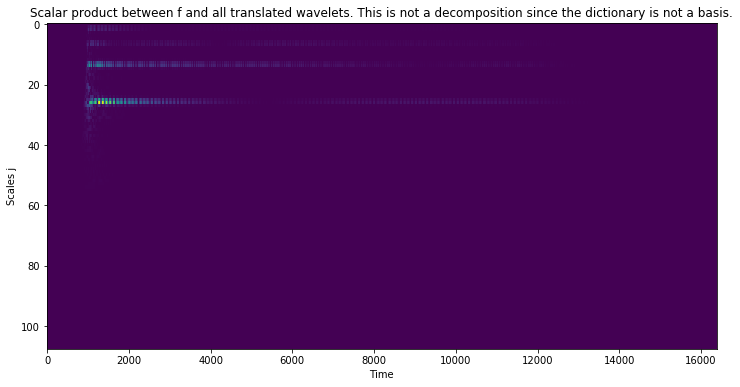

In [9]:
# We can very quickly observe the correlation between signal f and our wavelets by showing the image of scalar products.
f_fft = np.fft.fft(f)
a_scalar = np.real(np.fft.ifft(psi_hat * f_fft))

plt.figure(figsize=(12, 6))
plt.imshow(np.abs(a_scalar), aspect="auto")
plt.title("Scalar product between f and all translated wavelets. This is not a decomposition since the dictionary is not a basis.")
plt.xlabel("Time")
plt.ylabel("Scales j")
plt.show()

### Question 1: Fill the code for functions `reconstruction_error`, `l1_norm` and  `loss`

#### 1.a/ `reconstruction_echo` takes $a$ as input and returns $\|f - \Phi^* a\|_2^2$

In [10]:
def reconstruction_error(a):
    """
    Compute reconstruction Phi.a and compares it to signal f
    
    Inputs:
    ------
    a : numpy array of size (P, N)
        current representation

    Output:
    -------
    err: float
        Squarred error between signal f and reconstruction Phi.a
    """
    
    # we compute Phi.a as a convolution between wavelets psi and representation a.
    # This convolution is performed by computing the FFT of a_j and multiplying it by the FFT of psi_j
    # and then performing the inverse FFT

    a_hat = np.fft.fft(a, axis=1)  # Fourier transform of a, on each line a_j independantly
    a_filtered = np.real(np.fft.ifft(a_hat * psi_hat))
    reconstruction = np.sum(a_filtered, axis=0)  # sum over scale j

    diff = f - reconstruction
    err = np.sum(diff**2)  # squared norm, alternatively can be written using np.linalg.norm

    return err

#### 1.b/ `l1_norm` takes $a$ as input and returns $\| a \|_1$

In [11]:
def l1_norm(a):
    """
    Compute the L1 norm of a
    
    Input:
    ------
    a : numpy array of size (P, N)
        current representation

    Output:
    -------
    l1_norm: float
        L1 norm of a
    """
    l1_norm = np.sum(np.abs(a)) # L1 norm, alternatively can be written using np.linalg.norm
    
    return l1_norm

#### 1.c/ `loss` takes $a$ and $\lambda$ as input and returns $\mathcal L(a)$ as defined at the beginning of the notebook

In [12]:
def loss(a, la):
    """
    Compute the regularized reconstruction loss
    
    Input:
    ------
    a : numpy array of size (P, N)
        current reconstruction
    la : float
        dual variable lambda corresponding to regularization

    Output:
    -------
    loss: float
        regularized reconstruction loss
    """
    return .5 * reconstruction_error(a) + la * l1_norm(a)

### Question 2: What are the gradients with respect to $a$ ?
#### 2.a/ Gradient of $\|f - \Phi^*a\|_2^2$ with respect to $a$ ?
Let $h \in \mathbb C^N$ be a perturbation for the sake of gradient computation. We note $h^{(j)} \in \mathbb C^{J \times N}$ the matrix filled with zeros, exept for line $j$ which is equal to $h$. This way, $a + h^{(j)}$ is a perturbation of the $j^{th}$ line of $a$
$$
    \|f - \Phi^*(a + h^{(j)})\|_2^2 = \|f - \Phi^*a + \Phi^*h^{(j)}\|_2^2
    = \|f - \Phi^*a\|_2^2 + 2\langle Phi^* h^{(j)}, f - \Phi^*a \rangle + o(\|h\|)
$$
Now, we can write that
$$
    \Phi^* h^{(j)}[n] = \sum_{j'=0}^{J-1} \psi_{j'} \ast h^{(j)}_{j'} [n] = \psi_j \ast h [n]
$$
So, using the adjoint filter $\bar \psi_j[n] = \psi_j[N-1-n]^*$, we can now write:
\begin{align*}
    \|f - \Phi^*(a + h^{(j)})\|_2^2
    &= \|f - \Phi^*a\|_2^2 + 2\langle \psi_j \ast h, f - \Phi^*a \rangle + o(\|h\|) \\
    &= \|f - \Phi^*a\|_2^2 + \langle h, 2 \bar \psi_j \ast (f - \Phi^*a) \rangle + o(\|h\|)
\end{align*}
The right side of the hermitian product is the $j^{th}$ line of the gradient $\frac{\partial \|f - \Phi^*a\|_2^2}{\partial a}$
#### 2.b/ Gradient of $\| a \|_1$ with respect to $a$ ?
$$
    \frac{\partial \|a\|_1}{\partial a[j, n]} = \frac{\partial |a[j, n]|}{\partial a[j, n]} = sign(a[j, n])
$$
Which leads to 
$$
    \frac{\partial \|a\|_1}{\partial a} = sign(a)
$$
where the sign is computed pointwise.
#### 2.c/ Gradient of $\mathcal L(a)$ with respect to $a$ ?
By linearity, we get:
$$
    \frac{\partial \mathcal L(a)}{\partial a} = \frac{1}{2} \frac{\partial \|f - \Phi^*a\|_2^2}{\partial a} + \lambda \frac{\partial \|a\|_1}{\partial a}
$$
We can easily express each line of this gradient:
$$
    \frac{\partial \mathcal L(a)}{\partial a_j} = \bar \psi_j \ast (f - \Phi^*a) + \lambda sign(a_j)
$$

### Question 3: Fill the gradient functions of `reconstruction_echo`, `wavelet_l1_norm` and  `loss`, respectively called `gradient_reconstruction_echo`, `gradient_wavelet_l1_norm` and  `gradient_loss`

In [13]:
def gradient_reconstruction_error(a):
    """
    gradient of reconstruction_error(a) with respect to a
    """
    # first we compute reconstruction difference f - Phi.a
    # this is the variable diff computed in `reconstruction_error`, we use the same code
    a_hat = np.fft.fft(a, axis=1)  # Fourier transform of a, on each line a_j independantly
    a_filtered = np.real(np.fft.ifft(a_hat * psi_hat))
    reconstruction = np.sum(a_filtered, axis=0)  # sum over scale j
    diff = f - reconstruction  # vector of size N

    # now we compute the gradient, which is the convolution between diff and each adjoint filter \bar\psi_j
    # the fourier transform of the adjoint filter is \hat\bar\psi_j(omega) = - \hat\psi_j(omega)^*
    adjoint_psi_hat = - np.conjugate(psi_hat)  # matrix of size (J, N)
    diff_fft = np.fft.fft(diff)
    gradient = 2 * np.fft.ifft(adjoint_psi_hat * diff_fft, axis=1)

    # gradient must be real, but fft and ifft can create machine precision errors
    gradient = np.real(gradient)
    
    return gradient

In [14]:
def gradient_l1_norm(a):
    """
    gradient of l1_norm(a) with respect to a
    """
    gradient = np.sign(a)
    return gradient

In [15]:
def gradient_loss(a, la):
    """
    gradient of loss(a, la) with respect to a
    """
    return .5 * gradient_reconstruction_error(a) + la * gradient_l1_norm(a)

## Now, let us minimize the loss function in order to reconstruct $x$ from $y_0$

In [16]:
shape = np.shape(psi_hat)
a_0 = np.random.randn(*shape)

### Question 4: From this initialization, set a lambda and iteratively take gradient steps

#### 4.a/ Define the function `step` which takes as input $x_i$ (reconstruction at step $i$), $gL$ (which is the gradient of the loss with respect to $x_i$) and a learning rate `lr` and returns $x_{i+1}$

In [17]:
def step(a, gL, lr):
    return a - lr * gL

#### 4.b/ Chose a $\lambda$ and a learning rate, and iterate this gradient step. What happens ?

In [20]:
sigma = np.sum(np.abs(f) ** 2) * .01
la = np.sqrt(2 * np.log(np.size(a_0))) * sigma # regularization dual variable
# this formula comes from heuristics on how to choose lambda. The heuristic in "A signal tour of signal processing",
# chapter 12.4.2 states that for a noisy input, with noise level sigma, the dual variable lambda should be set to be
# smaller than sqrt(2 log(P))*sigma where P is the dictionary size
print("Choice of lambda: {}".format(la))

niter = 50  # number of gradient steps
lr = .05  # learning rate

reconstruction_err = []
regularization_err = []
full_err = []

a = a_0
for i in tqdm(range(niter)):
    gradient = gradient_loss(a, la)
    a = step(a, gradient, lr)

    reconstruction_err.append(reconstruction_error(a))
    regularization_err.append(l1_norm(a))
    full_err.append(loss(a, la))

reconstruction_err = np.array(reconstruction_err)
regularization_err = np.array(regularization_err)
full_err = np.array(full_err)

Choice of lambda: 9.07002696694796


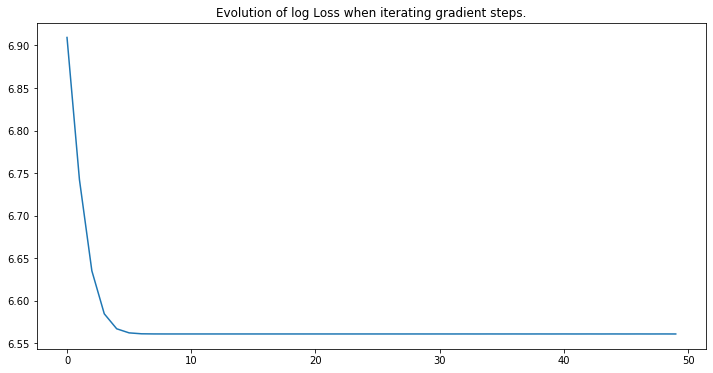

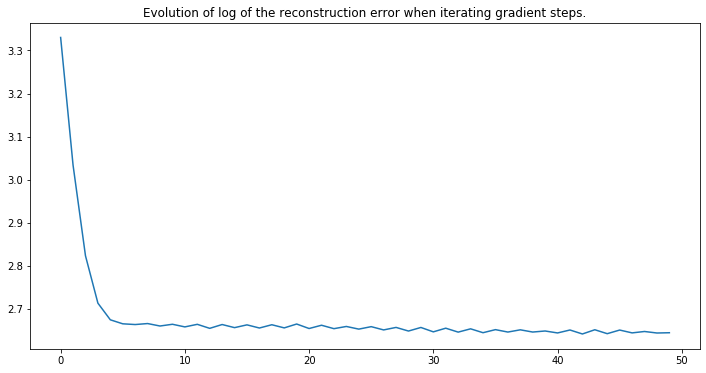

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(np.log10(full_err))
plt.title("Evolution of log Loss when iterating gradient steps.")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.log10(reconstruction_err))
plt.title("Evolution of log of the reconstruction error when iterating gradient steps.")
plt.show()

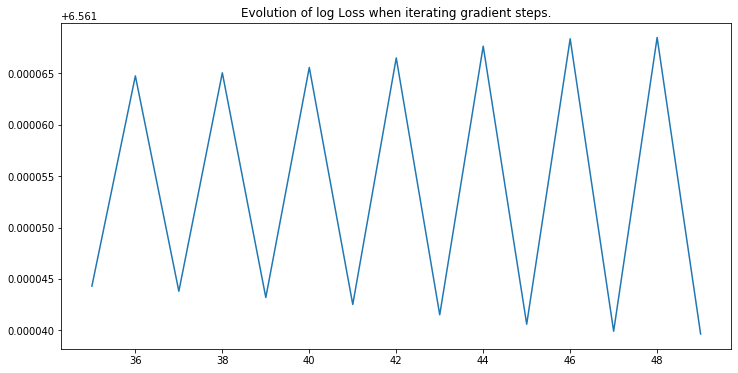

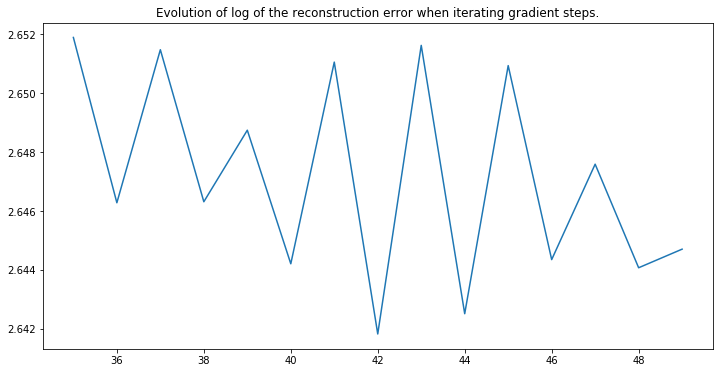

In [22]:
# Let's zoom
zoom = np.arange(niter-15, niter)

plt.figure(figsize=(12, 6))
plt.plot(zoom, np.log10(full_err[zoom]))
plt.title("Evolution of log Loss when iterating gradient steps.")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(zoom, np.log10(reconstruction_err[zoom]))
plt.title("Evolution of log of the reconstruction error when iterating gradient steps.")
plt.show()

The oscillation that can be observed above is due to the $L_1$ norm. Its gradient is not continuous in $0$, leading all coefficients which should be 0 to alternate sign after a while.
A better solution can be obtained with a smaller learning rate. However, it requires more iterations and will only make these iterations smaller and not make them disappear. One solution to get a truly sparse representation $a$ is to apply a thresholding operator, i.e. denoising the representation $a$.

In [23]:
print("Final squarred error, relative to the squarred norm of f: {}".format(
    reconstruction_err[-1] / np.sum(f ** 2)
))

Final squarred error, relative to the squarred norm of f: 2.609650716285558


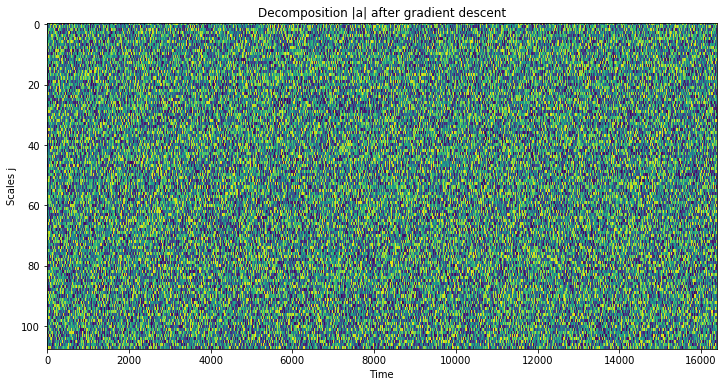

In [24]:
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(a), aspect='auto')
plt.title("Decomposition |a| after gradient descent")
plt.xlabel("Time")
plt.ylabel("Scales j")
plt.show()

Denoise $a$ with a soft thresholding operator. The threshold level is chosen to be equal to the learning rate. The result is better but still not convincing at all.

In [25]:
thr = lr
a_thr = np.copy(a)

# add thr to values below -thr
a_thr[a < -thr] = a_thr[a < -thr] + thr

# remove thr to values above thr
a_thr[a > thr] = a_thr[a > thr] - thr

# set other values to 0
mask_zero = np.logical_and(a >= -thr, a <= thr)
a_thr[mask_zero] = 0

Squarred error with thresholded mask, relative to the squarred norm of f: 2.0980832612383575


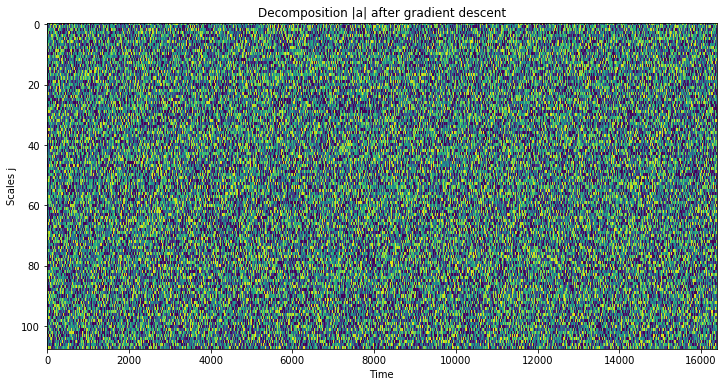

In [26]:
print("Squarred error with thresholded mask, relative to the squarred norm of f: {}".format(
    reconstruction_error(a_thr) / np.sum(f ** 2)
))

plt.figure(figsize=(12, 6))
plt.imshow(np.abs(a_thr), aspect='auto')
plt.title("Decomposition |a| after gradient descent")
plt.xlabel("Time")
plt.ylabel("Scales j")
plt.show()

Note that the relative squarred error is above $1$, meaning this is a reconstruction worse than $a=0$. 

### Question 5: Let's start again with $\|a\|_{1, \epsilon} = \sum_i \sqrt{a_i^2 + \epsilon^2}$ instead of $\|a\|_1$

As before, this norm acts independantly on each coefficient. Let us first compute the derivative in 1D:
let $x \in \mathbb R$
$$
    \frac{\partial \sqrt{x^2 + \epsilon^2}}{\partial x} = \frac{x}{\sqrt{x^2 + \epsilon^2}}
$$
This can be applied to each coordinate of a independantly:

In [41]:
epsilon = 1e-2

In [28]:
# redefine the regularization term
def l1_norm(a):
    return np.sum(np.sqrt(a**2 + epsilon**2))

def loss(a, la):
    return .5 * reconstruction_error(a) + la * l1_norm(a)

In [29]:
# redefine the gradient
def gradient_l1_norm(a):
    return a / np.sqrt(a**2 + epsilon**2)

def gradient_loss(a, la):
    """
    gradient of loss(a, la) with respect to a
    """
    return .5 * gradient_reconstruction_error(a) + la * gradient_l1_norm(a)

In [30]:
def step(a, gL, lr):
    return a - lr * gL

In [37]:
sigma = np.sum(np.abs(f) ** 2) * .01
la = np.sqrt(2 * np.log(np.size(a))) * sigma # regularization dual variable
# this formula comes from heuristics on how to choose lambda. The heuristic in "A signal tour of signal processing",
# chapter 12.4.2 states that for a noisy input, with noise level sigma, the dual variable lambda should be set to be
# smaller than sqrt(2 log(P))*sigma where P is the dictionary size
print("Choice of lambda: {}".format(la))

niter = 100  # number of gradient steps
lr = .004  # learning rate

reconstruction_err = []
regularization_err = []
full_err = []

a = a_0
for i in tqdm(range(niter)):
    gradient = gradient_loss(a, la)
    a = step(a, gradient, lr)

    reconstruction_err.append(reconstruction_error(a))
    regularization_err.append(l1_norm(a))
    full_err.append(loss(a, la))

reconstruction_err = np.array(reconstruction_err)
regularization_err = np.array(regularization_err)
full_err = np.array(full_err)

Choice of lambda: 9.07002696694796


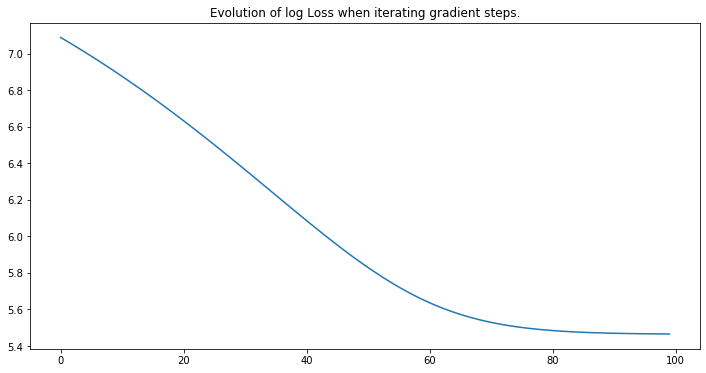

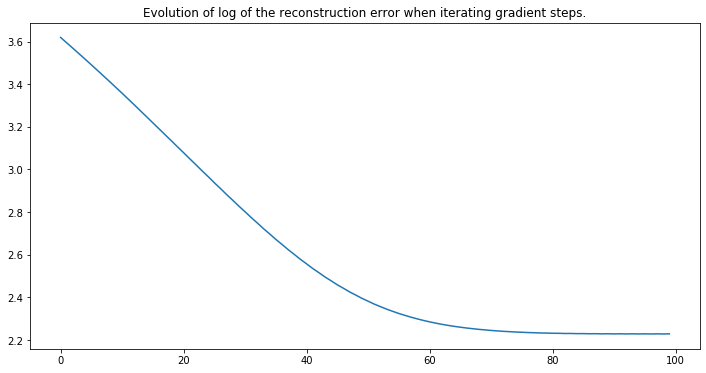

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(np.log10(full_err))
plt.title("Evolution of log Loss when iterating gradient steps.")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.log10(reconstruction_err))
plt.title("Evolution of log of the reconstruction error when iterating gradient steps.")
plt.show()

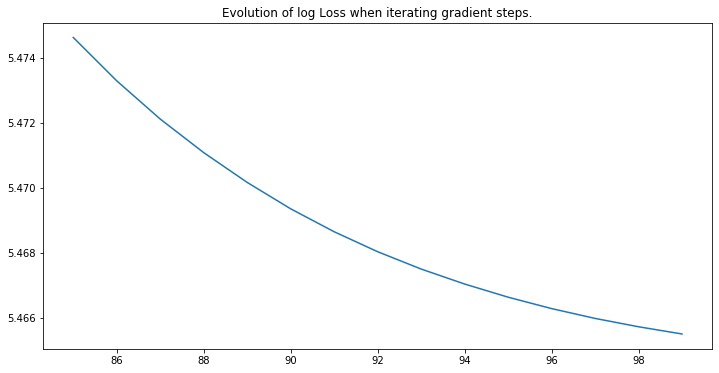

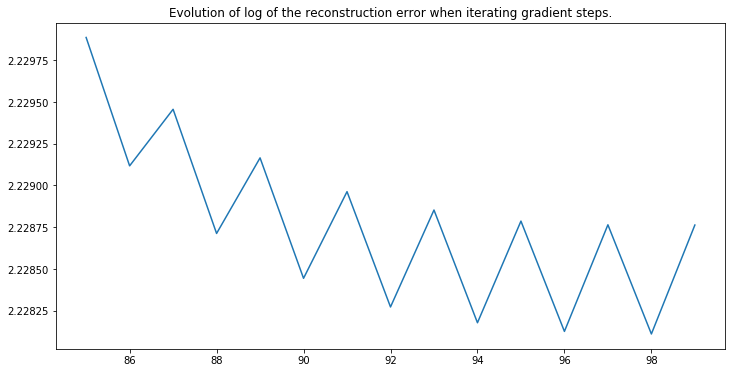

In [40]:
# Let's zoom
zoom = np.arange(niter-15, niter)

plt.figure(figsize=(12, 6))
plt.plot(zoom, np.log10(full_err[zoom]))
plt.title("Evolution of log Loss when iterating gradient steps.")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(zoom, np.log10(reconstruction_err[zoom]))
plt.title("Evolution of log of the reconstruction error when iterating gradient steps.")
plt.show()

The optimal is better than before, there is still oscillation due to the fact that the smoothed L1 loss is still pretty sharp when seen at the scale of the learning rate:

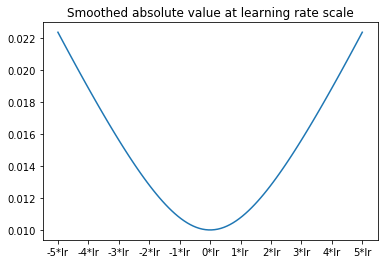

In [49]:
# Let's plot the smoothed absolute value:
num_lr = 5
xaxis = np.linspace(-num_lr*lr, num_lr*lr, 100)
smoothed_abs = np.sqrt(xaxis**2 + epsilon**2)

plt.figure()
plt.plot(xaxis, smoothed_abs)

xticks_pos = [nlr * lr for nlr in np.arange(-num_lr, num_lr+1)]
xticks_print = ["{}*lr".format(int(nlr)) for nlr in np.arange(-num_lr, num_lr+1)]
plt.xticks(xticks_pos, xticks_print)

plt.title("Smoothed absolute value at learning rate scale")
plt.show()

In [50]:
print("Final squarred error, relative to the squarred norm of f: {}".format(
    reconstruction_err[-1] / np.sum(f ** 2)
))

Final squarred error, relative to the squarred norm of f: 1.0014804505310781


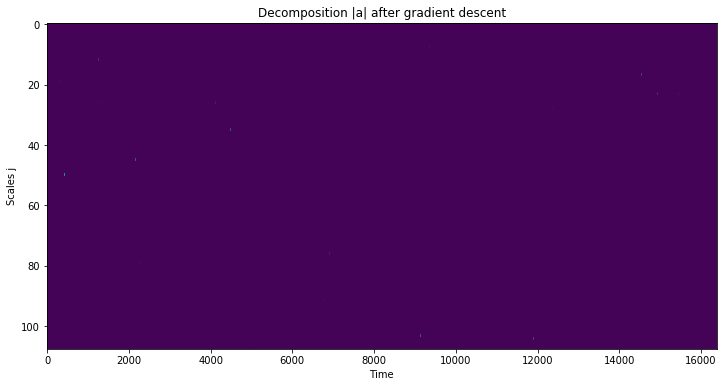

In [51]:
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(a), aspect='auto')
plt.title("Decomposition |a| after gradient descent")
plt.xlabel("Time")
plt.ylabel("Scales j")
plt.show()

The relative reconstruction error is near $1$ (indeed the reconstruction is almost $0$). Our constrain seems to enforce too much sparsity: the penalty $\lambda$ should be reduced. 

Try to change the penalty $\lambda$, then try doing this reconstruction with ISTA (Iterative Soft Thresholding Algorithm).